# PPE DETECTION

In [1]:
! nvidia-smi -L

GPU 0: Quadro M1200 (UUID: GPU-eacdf970-74eb-bd03-9e9c-cfe4cd683e83)


In [2]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: total: 31.2 ms
Wall time: 4.87 s


In [3]:
import ultralytics
print(ultralytics.__version__)

8.1.28


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [5]:
! wandb disabled

'wandb' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 1 # 100
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = 'E:/Ai_projects/PPE/datasets/PPE/'
    OUTPUT_DIR = './'

In [7]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [8]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: E:/Ai_projects/PPE/datasets/PPE/test
train: E:/Ai_projects/PPE/datasets/PPE/train
val: E:/Ai_projects/PPE/datasets/PPE/valid



Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



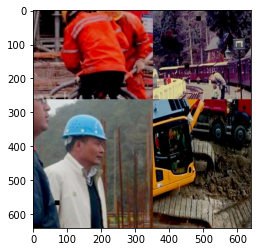

In [9]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()
example_image_path = r'E:/Ai_projects/PPE/datasets/PPE/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [10]:
def plot_random_images_from_folder(folder_path, num_images=40, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

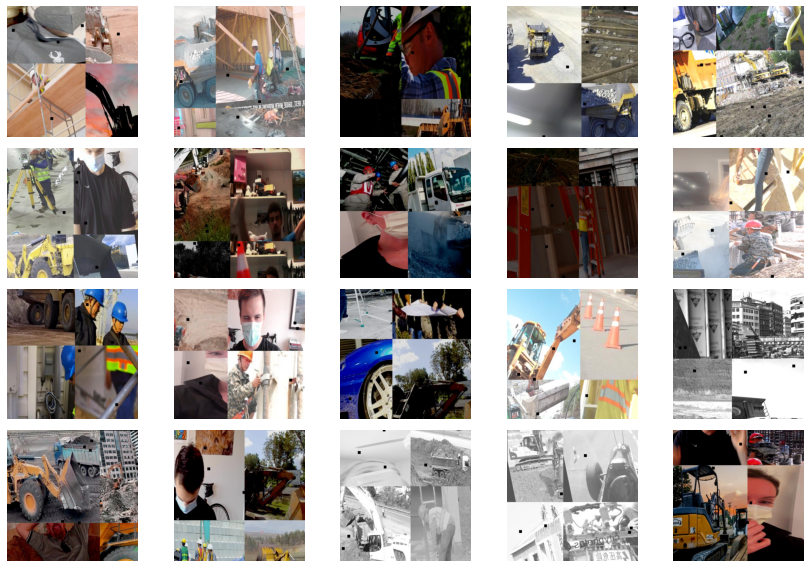

In [11]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

In [12]:
from PIL import Image

def get_image_properties(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        format = img.format
    return {'width': width, 'height': height, 'format': format}


In [13]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'format': 'JPEG'}

In [14]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: total: 1.38 s
Wall time: 15.8 s


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


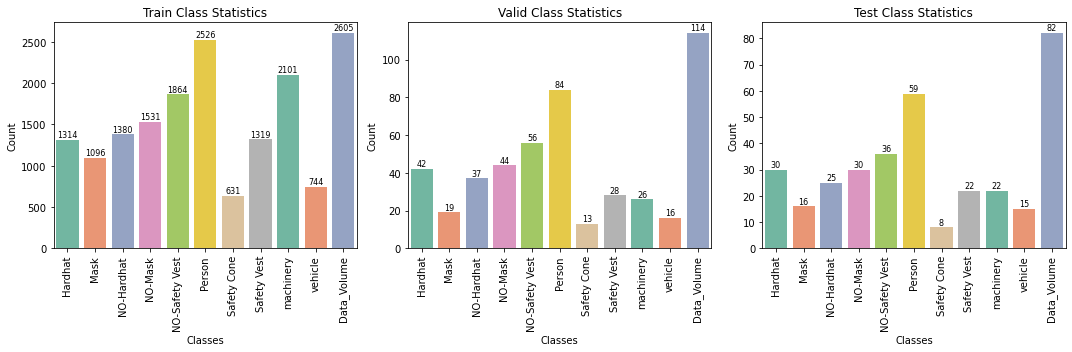

In [15]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [16]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: total: 1.23 s
Wall time: 13.3 s


In [17]:
CFG.BASE_MODEL_WEIGHTS

'yolov9e.pt'

In [18]:
device = 'cpu'
model = YOLO(CFG.BASE_MODEL_WEIGHTS)
results = model.predict(
    source=example_image_path,
    classes=[0],
    conf=0.30,
    device=device,
    imgsz=(img_properties['height'], img_properties['width']),
    save=True,
    save_txt=True,
    save_conf=True,
    exist_ok=True,
)



image 1/1 E:\Ai_projects\PPE\datasets\PPE\train\images\-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 8 persons, 2849.8ms
Speed: 8.7ms preprocess, 2849.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
1 label saved to runs\detect\predict\labels


In [19]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
file_path = 'E:/Ai_projects/PPE/datasets/PPE/results_yolov8n_100e/kaggle/working/runs/detect/predict/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'


In [20]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  1
Batch:  16


In [21]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [22]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = 1,  # Reduced batch size
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = 'cpu',  # Use CPU
    verbose = False,
)


Ultralytics YOLOv8.1.28 🚀 Python-3.9.12 torch-1.12.1+cpu CPU (Intel Xeon E3-1505M v6 3.00GHz)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: task=detect, mode=train, model=yolov9e.pt, data=./data.yaml, epochs=1, time=None, patience=20, batch=1, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=yolov9e_ppe_css_1_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

train: Scanning E:\Ai_projects\PPE\datasets\PPE\train\labels.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|█████

train: WARNING ⚠️ E:\Ai_projects\PPE\datasets\PPE\train\images\004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ E:\Ai_projects\PPE\datasets\PPE\train\images\construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed



val: Scanning E:\Ai_projects\PPE\datasets\PPE\valid\labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|███████


Plotting labels to runs\detect\yolov9e_ppe_css_1_epochs\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\yolov9e_ppe_css_1_epochs
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.446      2.398      1.704          6        640: 100%|██████████| 2605/2605 [12:59:47<00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [06:17


                   all        114        697      0.345      0.323      0.236     0.0959

1 epochs completed in 13.118 hours.
Optimizer stripped from runs\detect\yolov9e_ppe_css_1_epochs\weights\last.pt, 117.3MB
Optimizer stripped from runs\detect\yolov9e_ppe_css_1_epochs\weights\best.pt, 117.3MB

Validating runs\detect\yolov9e_ppe_css_1_epochs\weights\best.pt...
Ultralytics YOLOv8.1.28 🚀 Python-3.9.12 torch-1.12.1+cpu CPU (Intel Xeon E3-1505M v6 3.00GHz)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [05:40


                   all        114        697      0.345      0.324      0.236     0.0958
Speed: 2.6ms preprocess, 2949.2ms inference, 0.0ms loss, 23.5ms postprocess per image
Results saved to runs\detect\yolov9e_ppe_css_1_epochs
CPU times: total: 1d 6h 56min 25s
Wall time: 13h 13min 6s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001BAC0DF79D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [23]:
img_properties

{'width': 640, 'height': 640, 'format': 'JPEG'}

In [24]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.28 🚀 Python-3.9.12 torch-1.12.1+cpu CPU (Intel Xeon E3-1505M v6 3.00GHz)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs\detect\yolov9e_ppe_css_1_epochs\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1

requirements: AutoUpdate success ✅ 24.6s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 10...
ONNX: export success ✅ 56.3s, saved as 'runs\detect\yolov9e_ppe_css_1_epochs\weights\best.onnx' (219.2 MB)

Export complete (64.7s)
Results saved to C:\Users\Salman Tariq\Untitled Folder 1\PPE\r

'runs\\detect\\yolov9e_ppe_css_1_epochs\\weights\\best.onnx'

In [25]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov9e_ppe_css_1_epochs\\confusion_matrix.png',
 './runs/detect/yolov9e_ppe_css_1_epochs\\confusion_matrix_normalized.png',
 './runs/detect/yolov9e_ppe_css_1_epochs\\F1_curve.png',
 './runs/detect/yolov9e_ppe_css_1_epochs\\PR_curve.png',
 './runs/detect/yolov9e_ppe_css_1_epochs\\P_curve.png',
 './runs/detect/yolov9e_ppe_css_1_epochs\\results.png',
 './runs/detect/yolov9e_ppe_css_1_epochs\\R_curve.png',
 './runs/detect/yolov9e_ppe_css_1_epochs\\labels.jpg',
 './runs/detect/yolov9e_ppe_css_1_epochs\\labels_correlogram.jpg']

./runs/detect/yolov9e_ppe_css_1_epochs\F1_curve.png


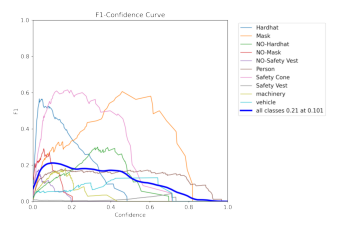



./runs/detect/yolov9e_ppe_css_1_epochs\PR_curve.png


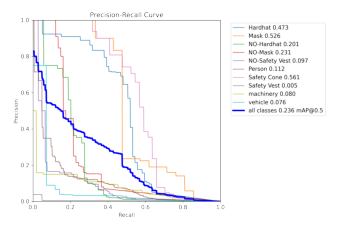



./runs/detect/yolov9e_ppe_css_1_epochs\P_curve.png


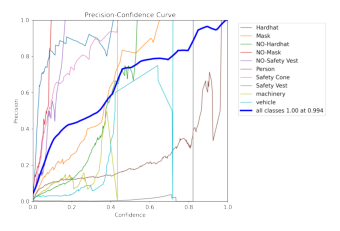



./runs/detect/yolov9e_ppe_css_1_epochs\R_curve.png


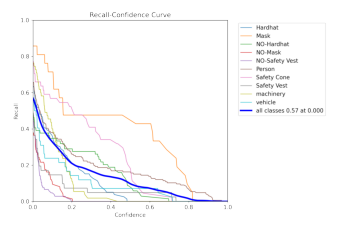



./runs/detect/yolov9e_ppe_css_1_epochs\confusion_matrix.png


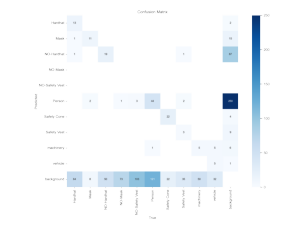



./runs/detect/yolov9e_ppe_css_1_epochs\confusion_matrix_normalized.png


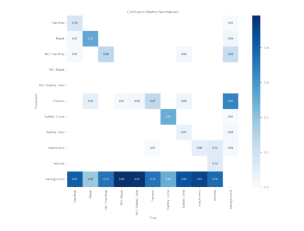



./runs/detect/yolov9e_ppe_css_1_epochs\labels.jpg


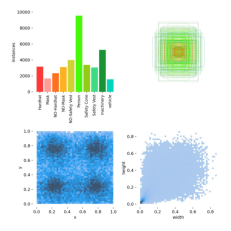



./runs/detect/yolov9e_ppe_css_1_epochs\labels_correlogram.jpg


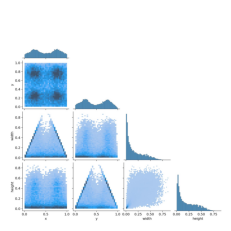



./runs/detect/yolov9e_ppe_css_1_epochs\results.png


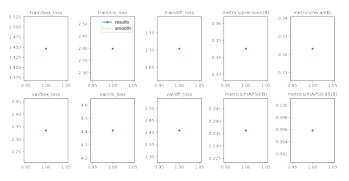

In [26]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [27]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.446,2.3981,1.7038,0.34506,0.3231,0.23623,0.09585,2.3349,4.4087,2.4081,0.000238,0.000238,0.000238


In [28]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  1.446 , on epoch:  1 


Best Validation Box loss:  2.3349 , on epoch:  1 


Best Training Cls loss:  2.3981 , on epoch:  1 


Best Validation Cls loss:  4.4087 , on epoch:  1 


Best Training DFL loss:  1.7038 , on epoch:  1 


Best Validation DFL loss:  2.4081 , on epoch:  1 



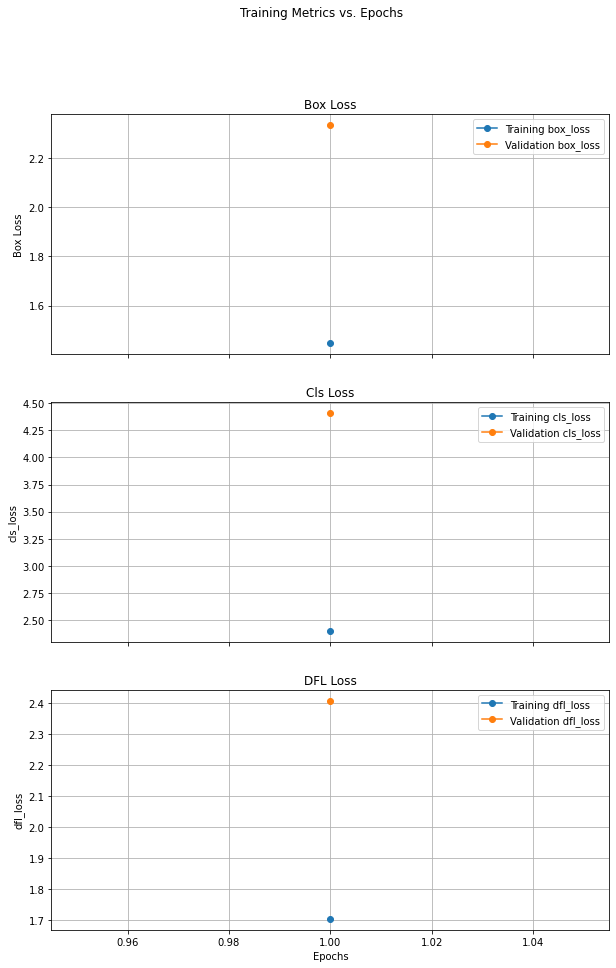

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation Box Loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [ ]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov9e_ppe_css_1_epochs\val_batch2_pred.jpg


./runs/detect/yolov9e_ppe_css_1_epochs\val_batch1_pred.jpg


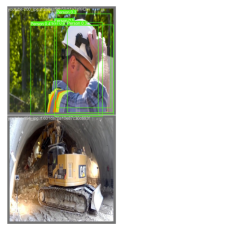

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

In [1]:
import cv2
from ultralytics import YOLO

# Load the YOLO model
model = YOLO('yolov5s.pt')

# Video file path
video_path = 'E:/Ai_projects/PPE/datasets/PPE/source_files/source_files/indianworkers.mp4'

# Use the predict method with stream=True to process the video frame by frame
results = model.predict(video_path, stream=True)

# Get the first frame to initialize the video writer
frame_result = next(results)
height, width, _ = frame_result.orig_img.shape
video_writer = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

# Iterate over the generator to access the detection results for each frame
for frame_result in results:
    # Display the frame with detections
    img = frame_result.orig_img

    # Get the detection results for this frame
    boxes = frame_result.boxes
    labels = frame_result.get_field('labels')
    confidences = frame_result.get_field('scores')

    # Print the number of detections for debugging
    print(f"Number of detections: {len(boxes)}")

    # Draw bounding boxes on the frame
    for box, label, confidence in zip(boxes, labels, confidences):
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{model.names[int(label)]}: {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow('Video', img)
    video_writer.write(img)

    # Press 'q' to stop the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video writer and resources
video_writer.release()
cv2.destroyAllWindows()


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


video 1/1 (frame 1/648) E:\Ai_projects\PPE\datasets\PPE\source_files\source_files\indianworkers.mp4: 384x640 3 persons, 544.1ms
video 1/1 (frame 2/648) E:\Ai_projects\PPE\datasets\PPE\source_files\source_files\indianworkers.mp4: 384x640 3 persons, 484.4ms


AttributeError: 'Results' object has no attribute 'get_field'. See valid attributes below.

    A class for storing and manipulating inference results.

    Attributes:
        orig_img (numpy.ndarray): Original image as a numpy array.
        orig_shape (tuple): Original image shape in (height, width) format.
        boxes (Boxes, optional): Object containing detection bounding boxes.
        masks (Masks, optional): Object containing detection masks.
        probs (Probs, optional): Object containing class probabilities for classification tasks.
        keypoints (Keypoints, optional): Object containing detected keypoints for each object.
        speed (dict): Dictionary of preprocess, inference, and postprocess speeds (ms/image).
        names (dict): Dictionary of class names.
        path (str): Path to the image file.

    Methods:
        update(boxes=None, masks=None, probs=None, obb=None): Updates object attributes with new detection results.
        cpu(): Returns a copy of the Results object with all tensors on CPU memory.
        numpy(): Returns a copy of the Results object with all tensors as numpy arrays.
        cuda(): Returns a copy of the Results object with all tensors on GPU memory.
        to(*args, **kwargs): Returns a copy of the Results object with tensors on a specified device and dtype.
        new(): Returns a new Results object with the same image, path, and names.
        plot(...): Plots detection results on an input image, returning an annotated image.
        show(): Show annotated results to screen.
        save(filename): Save annotated results to file.
        verbose(): Returns a log string for each task, detailing detections and classifications.
        save_txt(txt_file, save_conf=False): Saves detection results to a text file.
        save_crop(save_dir, file_name=Path("im.jpg")): Saves cropped detection images.
        tojson(normalize=False): Converts detection results to JSON format.
    

In [ ]:
# Assuming you have already loaded the model and have the video file path
video_path = 'E:/Ai_projects/PPE/datasets/PPE/source_files/source_files/indianworkers.mp4'

# Use the detect_video method to detect objects in the video
results = model.detect_video(video_path)

# Display the video with detections
results.show()
